In [1]:
from ib_insync import *
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings("ignore")



In [2]:
ib = IB()

In [3]:
util.startLoop()
ib.disconnect()
ib.connect('127.0.0.1', 7497, clientId = 200)

<IB connected to 127.0.0.1:7497 clientId=200>

In [4]:
ib.run()

In [5]:
def extract_info(accounts, tag):
    for acc in accounts:
        if tag == acc.tag:
            return acc.value
    return None

In [6]:
account = ib.accountSummary()
print("Net worth:", extract_info(account, "NetLiquidation"))
print("Cash:", extract_info(account, "TotalCashValue"))

Net worth: 1049178.87
Cash: 1040262.53


In [7]:
bars = ib.reqHistoricalData(
            # contract=Crypto('BTC', "PAXOS", "USD"), #, primaryExchange='NASDAQ'),
            contract=Stock('GOOG', 'SMART', 'USD', primaryExchange='NASDAQ'),
            endDateTime='',
            durationStr=f'{60 * 60 * 1} S',
            barSizeSetting='1 min',
            whatToShow='MIDPOINT',
            useRTH=True, 
            formatDate = 2
        )


In [8]:
util.df(bars)

,date,open,high,low,close,volume,average,barCount
0,2024-06-04 15:42:00+00:00,174.39,174.56,174.38,174.50,-1.0,-1.0,-1
1,2024-06-04 15:43:00+00:00,174.51,174.51,174.40,174.41,-1.0,-1.0,-1
2,2024-06-04 15:44:00+00:00,174.41,174.43,174.36,174.37,-1.0,-1.0,-1
3,2024-06-04 15:45:00+00:00,174.37,174.51,174.37,174.47,-1.0,-1.0,-1
4,2024-06-04 15:46:00+00:00,174.47,174.49,174.44,174.46,-1.0,-1.0,-1
...,...,...,...,...,...,...,...,...
56,2024-06-04 16:38:00+00:00,173.95,174.04,173.91,174.01,-1.0,-1.0,-1
57,2024-06-04 16:39:00+00:00,174.02,174.05,173.98,174.03,-1.0,-1.0,-1
58,2024-06-04 16:40:00+00:00,174.03,174.09,174.01,174.07,-1.0,-1.0,-1
59,2024-06-04 16:41:00+00:00,174.08,174.08,174.00,174.04,-1.0,-1.0,-1


Position: 0
Hold position
519.4
Previous Stoch_RSI(%K_FAST) 30.65944600920702
Previous Stoch_RSI(%K_SLOW) 43.55314864213215
Previous Stoch_RSI(%D_SLOW) 39.839843891857385
RSI(Smoothed) 40.97829739851306
Bollinger Lower Band 518.6604108669488
Bollinger Upper Band 523.8500653235272
Simple Moving Average 521.255238095238 

The fee is: 1
Net Worth: 10000.0
Cash: 10000.0
Position: 0.0
Position: 0
2024-04-09 14:00:00+00:00 Buy
Current Price: 518.11 
Created Buy Order: 518.3943528159319 
Quantity: 1 
Time: 2024-04-09 14:00:00+00:00
518.11
Previous Stoch_RSI(%K_FAST) 3.689179451361193
Previous Stoch_RSI(%K_SLOW) 44.78287512591921
Previous Stoch_RSI(%D_SLOW) 43.731749125486424
RSI(Smoothed) 37.721435328663304
Bollinger Lower Band 518.3943528159319
Bollinger Upper Band 523.5342186126394
Simple Moving Average 520.9642857142857 

We are buying, fee: 1, next price: 518.11, buy quantity: 1, cash: 10000.0, position: 518.11
The fee is: 1
Net Worth: 9999.0
Cash: 9480.89
Position: 518.11
Position: 1
202

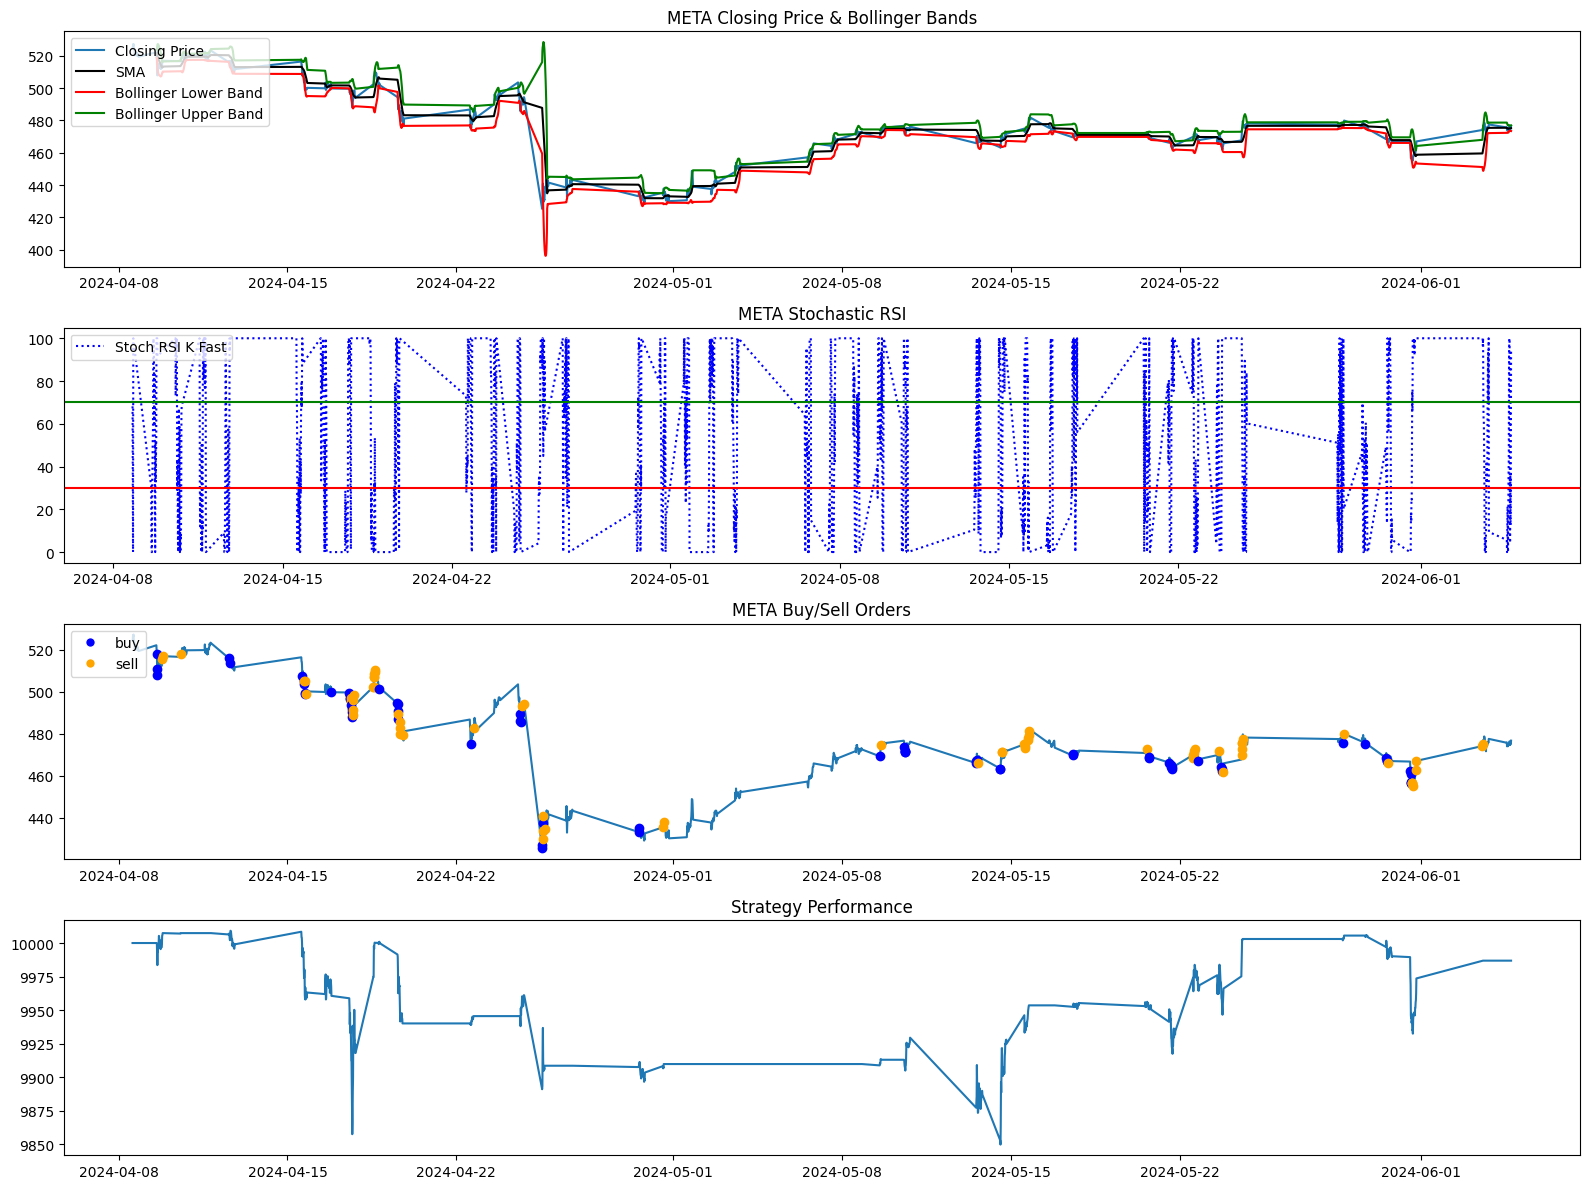

In [164]:
from ib_insync import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as plt_dates
import datetime as dt
from matplotlib.lines import Line2D

class TradingBot:

    def __init__(self, ib: IB, args):
        # IB connection
        self.ib = ib

        # Stoch RSI Information
        self.avg_gain, self.avg_loss = 0, 0
        self.rsi,  self.rsi_array = 0, []
        self.rsi_period, self.stoch_period = args['rsi_period'], args['stochastic_period']
        self.k_slow_period, self.d_slow_period = args['k_slow_period'], args['d_slow_period']
        self.k_fast_array, self.k_slow_array, self.d_slow_array = {'time':[],'k_fast':[]}, {'time':[],'k_slow':[]}, {'time':[],'d_slow':[]}
        self.stoch_upper, self.stoch_lower = args['stochastic_upper_band'], args['stochastic_lower_band']
        self.percent = args['limit_percent']
        self.initial_cash = args['initial_cash']

        # Store limit order and stop loss
        self.limit_orders = []
        self.stop_loss = []

        # Bollinger Band Information
        self.sma_period, self.sma_array = args['simple_moving_average_period'], []
        self.deviation = args['bollinger_band_standard_deviation']
        self.bb = {'time':[],'sma': [],'lower_band': [],'upper_band': []}

        # Buy Sell Algorithm Information
        self.orders = {'time':[],'order_limit': [],'order_type': []}
        self.time_look_back = args['time_look_back']
        self.asset_interval = args['asset_interval']
        self.status = 0
        self.buy_quantity = args['buy_quantity']

        # IB trading fees and general information
        self.ticker = args['ticker']
        self.show_times = args['show_times']
        self.closing_price_array, self.closing_times = [], []
        self.checked_prices, self.checked_times = [], []
        self.general_trade_fee = 0.01 # commission fee
        self.position = 0

        self.positions = [0]
        self.cash = [self.initial_cash]
        self.net_worth = [self.initial_cash]

    def simple_moving_average(self, arr, period):
        return np.sum(arr) / period

    def wilders_moving_average(self, period, close, prev_moving_average):
        return ((prev_moving_average * (period - 1)) + close) / period

    def rsi_calc(self, avg_gain, avg_loss):
        rs = avg_gain / (avg_loss + 0.00000001)
        return 100 - (100 / (1 + rs))

    def k_fast_stoch(self, rsi_array):
        close = rsi_array[-1]
        high = np.amax(rsi_array)
        low = np.amin(rsi_array)
        return abs(((close - low) / (high - low + 0.00000001))) * 100

    def bollinger_bands(self, kline_array, sma_period, deviation_number, time):
        recent_numbers = kline_array[len(kline_array) - sma_period:]
        sma = self.simple_moving_average(sum(recent_numbers), sma_period)
        self.bb['sma'].append(sma)
        squared_errors = [pow(x - sma, 2) for x in recent_numbers]
        standard_deviation = (sum(squared_errors) / len(squared_errors)) ** 0.5
        upper_band = sma + standard_deviation * deviation_number
        lower_band = sma - standard_deviation * deviation_number
        self.bb['lower_band'].append(lower_band)
        self.bb['upper_band'].append(upper_band)
        self.bb['time'].append(time)
        return sma, upper_band, lower_band, standard_deviation

    def print_values(self):
        print(self.checked_prices[-1])
        print('Previous Stoch_RSI(%K_FAST)', self.k_fast_array['k_fast'][-1])
        print('Previous Stoch_RSI(%K_SLOW)', self.k_slow_array['k_slow'][-1])
        print('Previous Stoch_RSI(%D_SLOW)', self.d_slow_array['d_slow'][-1])
        print('RSI(Smoothed)', self.rsi)
        print('Bollinger Lower Band', self.bb['lower_band'][-1])
        print('Bollinger Upper Band', self.bb['upper_band'][-1])
        print('Simple Moving Average', self.bb['sma'][-1], '\n')

    def backtest(self):
        end_time = ''
        # start_time = end_time - dt.timedelta(days=int(self.time_look_back.split()[0]))
        
        bars = self.ib.reqHistoricalData(
            # contract=Crypto(self.ticker, "Paxos", "USD"), 
            contract=Stock(self.ticker, "SMART", "USD", primaryExchange='NASDAQ'),
            endDateTime=end_time,
            durationStr=self.time_look_back,
            barSizeSetting=self.asset_interval,
            whatToShow='MIDPOINT',
            useRTH=True, 
            formatDate = 2,
            keepUpToDate=True,
        )

        # print(bars)

        self.closing_times = [bar.date for bar in bars][:-1]
        self.closing_price_array = [bar.close for bar in bars][:-1]
        self.checked_prices = []

        gain, loss = 0, 0
        for x in range(0, len(self.closing_price_array)-1):
            change = self.closing_price_array[x+1] - self.closing_price_array[x]
            self.checked_prices.append(self.closing_price_array[x+1])
            self.checked_times.append(self.closing_times[x+1])
            if change > 0:
                gain += change
            elif change < 0:
                loss += abs(change)

            if x == self.rsi_period:
                self.avg_gain = self.simple_moving_average(gain, self.rsi_period)
                self.avg_loss = self.simple_moving_average(loss, self.rsi_period)
                self.rsi = self.rsi_calc(self.avg_gain, self.avg_loss)
                self.rsi_array.append(self.rsi)
                gain, loss = 0, 0

            elif x > self.rsi_period:
                self.avg_gain = self.wilders_moving_average(self.rsi_period, gain, self.avg_gain)
                self.avg_loss = self.wilders_moving_average(self.rsi_period, loss, self.avg_loss)
                self.rsi = self.rsi_calc(self.avg_gain, self.avg_loss)
                self.rsi_array.append(self.rsi)
                gain, loss = 0, 0

                if len(self.rsi_array) >= self.stoch_period:
                    k_fast = self.k_fast_stoch(self.rsi_array[-self.stoch_period:])
                    self.k_fast_array['k_fast'].append(k_fast)
                    self.k_fast_array['time'].append(self.closing_times[x])

                    if len(self.k_fast_array['k_fast']) >= self.k_slow_period:
                        k_slow = self.simple_moving_average(self.k_fast_array['k_fast'][-self.k_slow_period:], self.k_slow_period)
                        self.k_slow_array['k_slow'].append(k_slow)
                        self.k_slow_array['time'].append(self.closing_times[x])

                        if len(self.k_slow_array['k_slow']) >= self.d_slow_period:
                            d_slow = self.simple_moving_average(self.k_slow_array['k_slow'][-self.d_slow_period:], self.d_slow_period)
                            self.d_slow_array['d_slow'].append(d_slow)
                            self.d_slow_array['time'].append(self.closing_times[x])

                            self.bollinger_bands(self.checked_prices, self.sma_period, self.deviation, self.checked_times[x])

                            self.buy_sell(current_time=self.checked_times[-1])
                        
                        else:
                            self.positions.append(self.positions[-1])
                            self.cash.append(self.cash[-1])
                            self.net_worth.append(self.net_worth[-1])
                    else:
                        self.positions.append(self.positions[-1])
                        self.cash.append(self.cash[-1])
                        self.net_worth.append(self.net_worth[-1])
                else:
                    self.positions.append(self.positions[-1])
                    self.cash.append(self.cash[-1])
                    self.net_worth.append(self.net_worth[-1])
            else:
                    self.positions.append(self.positions[-1])
                    self.cash.append(self.cash[-1])
                    self.net_worth.append(self.net_worth[-1])

        # self.buy_sell(current_time=self.checked_times[-1])
        self.plot_orders()

    def buy_sell(self, current_time):
        next_price = self.checked_prices[-1]
        # stock=Crypto(self.ticker, "Paxos", "USD") 
        stock=Stock(self.ticker, "SMART", "USD", primaryExchange='NASDAQ')
        print(f"Position: {self.position}")
        if self.k_fast_array['k_fast'][-1] <= self.stoch_lower and next_price <= self.bb['lower_band'][-1] and self.cash[-1] > next_price * self.buy_quantity:
            self.buy_stock(current_time, next_price)
        # If it touches the limit order and stop loss, sell
        elif self.k_fast_array['k_fast'][-1] >= self.stoch_upper and next_price >= self.bb['upper_band'][-1] and self.position > 0:
            self.sell_stock(current_time, next_price)
            self.stop_loss.pop()
            self.limit_orders.pop()
        elif self.position > 0:
            limit_order_hit = False
            for i in range(len(self.limit_orders)):
                if next_price >= self.limit_orders[i] or next_price <= self.stop_loss[i]:
                    print("WOW, stop loss or limit order hit!", current_time, next_price, self.limit_orders[i], self.stop_loss[i])
                    self.sell_stock(current_time, next_price)
                    self.limit_orders.pop(i)
                    self.stop_loss.pop(i)
                    limit_order_hit = True
                    break
            if not limit_order_hit:
                print("Hold position")
                self.print_values()
                self.orders['time'].append(current_time)
                self.orders['order_limit'].append(None)
                self.orders['order_type'].append('hold')
        else:
            print("Hold position")
            self.print_values()
            self.orders['time'].append(current_time)
            self.orders['order_limit'].append(None)
            self.orders['order_type'].append('hold')

        self.positions.append(self.position * next_price)
        # Assume if ticker's price > $100, fee will be $1, otherwise 1% of ticker's price
        fee = min(self.general_trade_fee * next_price , 1) 
        if self.orders["order_type"][-1] == 'buy':
            print(f"We are buying, fee: {fee}, next price: {next_price}, buy quantity: {self.buy_quantity}, cash: {self.cash[-1]}, position: {self.positions[-1]}")
            self.cash.append(self.cash[-1] - next_price * self.buy_quantity - fee)
        elif self.orders["order_type"][-1] == 'sell':
            self.cash.append(self.cash[-1] + next_price * self.buy_quantity - fee)
        else:
            self.cash.append(self.cash[-1])
        self.net_worth.append(self.cash[-1] + self.positions[-1])
        print(f"The fee is: {fee}")
        print(f"Net Worth: {self.net_worth[-1]}")
        print(f"Cash: {self.cash[-1]}")
        print(f"Position: {self.positions[-1]}")

        print("====================================")

    def sell_stock(self, current_time, next_price):
        self.status = 0
        print(f"{current_time} Sell")
        # order = MarketOrder("Sell", self.buy_quantity)
        # self.ib.placeOrder(stock, order)
        print('Current Price:', next_price, '\nCreated Sell Order:', self.bb['upper_band'][-1], '\nQuantity:', self.buy_quantity, '\nTime:', current_time)
        self.position -= 1
        self.orders['time'].append(current_time)
        self.orders['order_limit'].append(next_price)
        self.orders['order_type'].append('sell')
        self.print_values()

    def buy_stock(self, current_time, next_price):
        self.status = 1
        print(f"{current_time} Buy")
        # order = MarketOrder("Buy", self.buy_quantity)
        # self.ib.placeOrder(stock, order)
        print('Current Price:', next_price, '\nCreated Buy Order:', self.bb['lower_band'][-1], '\nQuantity:', self.buy_quantity, '\nTime:', current_time)
        self.position += 1
        self.orders['time'].append(current_time)
        self.orders['order_limit'].append(next_price)
        self.orders['order_type'].append('buy')
        self.print_values()

            # Set up stop loss and limit order
        stop_loss_price = next_price - next_price * self.percent
        limit_order_price = next_price + next_price * self.percent
        self.limit_orders.append(limit_order_price)
        self.stop_loss.append(stop_loss_price)

    def plot_orders(self):
        plot_data = [
            {'time': self.k_fast_array['time'], 'values': self.k_fast_array['k_fast'], 'label': 'Stoch RSI K Fast', 'color': 'b', 'linestyle': 'dotted'},
            # {'time': self.k_slow_array['time'], 'values': self.k_slow_array['k_slow'], 'label': 'Stoch RSI K Slow', 'color': 'b'},
            # {'time': self.d_slow_array['time'], 'values': self.d_slow_array['d_slow'], 'label': 'Stoch RSI D Slow', 'color': 'r'},
            {'time': self.bb['time'], 'values': self.bb['sma'], 'label': 'SMA', 'color': 'black'},
            {'time': self.bb['time'], 'values': self.bb['lower_band'], 'label': 'Bollinger Lower Band', 'color': 'red'},
            {'time': self.bb['time'], 'values': self.bb['upper_band'], 'label': 'Bollinger Upper Band', 'color': 'green'},
        ]

        plt.figure(figsize=(16, 12))
        ax1 = plt.subplot(411)
        ax2 = plt.subplot(412)
        ax3 = plt.subplot(413)
        ax4 = plt.subplot(414)

        ax1.set_title(f"{self.ticker} Closing Price & Bollinger Bands")
        ax1.plot(self.checked_times, self.checked_prices, label='Closing Price')
        for data in plot_data[1:]:
            ax1.plot(data['time'], data['values'], label=data['label'], color=data['color'])
        ax1.legend(loc='upper left')

        ax2.set_title(f"{self.ticker} Stochastic RSI")
        data = plot_data[0]
        ax2.plot(data['time'], data['values'], label=data['label'], color=data['color'], linestyle=data.get('linestyle'))
        ax2.axhline(y=self.stoch_lower, color='r', linestyle='-')
        ax2.axhline(y=self.stoch_upper, color='g', linestyle='-')
        ax2.legend(loc='upper left')

        ax3.set_title(f"{self.ticker} Buy/Sell Orders")
        ax3.plot(self.checked_times, self.checked_prices, label='Closing Price')
        colors = {'buy': 'blue', 'sell': 'orange'}
        for order_time, order_price, order_type in zip(self.orders['time'], self.orders['order_limit'], self.orders['order_type']):
            if order_type == 'hold': continue
            ax3.plot(order_time, order_price, 'o', color=colors[order_type])
        circle_buy = Line2D([0],[0], color = "w", label="buy", marker='o', markerfacecolor='blue', markersize='7')
        circle_sell = Line2D([0],[0], color = "w", label="sell", marker='o', markerfacecolor='orange', markersize='7')
        ax3.legend(loc='upper left', handles=[circle_buy, circle_sell])

        ax4.set_title(f"Strategy Performance")
        print(len(self.checked_times), len(self.net_worth), len(self.cash), len(self.positions))
        ax4.plot(self.checked_times, self.net_worth, label='Net Worth')
        # ax4.plot(self.checked_times, self.cash, label='Cash')
        # ax4.plot(self.checked_times, self.positions, label='Positions')        
        plt.tight_layout()
        plt.show()


# Define bot parameters
args = {
    # Stochastic RSI Attributes
    'rsi_period': 14,
    'stochastic_period': 9,
    'k_slow_period': 3,
    'd_slow_period': 3,

    # Bollinger Band Attributes
    'simple_moving_average_period': 21,
    'bollinger_band_standard_deviation': 2,

    # Buy and Sell Attributes
    'ticker': 'META',  
    'stochastic_upper_band': 70,
    'stochastic_lower_band': 30,
    'time_look_back':  f'2 M', 
    'asset_interval': '15 mins', 
    'buy_quantity': 1, 
    'show_times': 500,
    'limit_percent': 0.015,
    'initial_cash': 1e4,
}

# Create and run bot
bot = TradingBot(ib, args)
while True:
    bot.backtest()
    # ib.sleep(5 * 60)
    break


In [165]:
def sharpe_ratio(rate):
    r_f = 0 # 0.005 / 252  # 0.5% (US Treasury)
    r_m = rate.mean()
    sigma = rate.std()
    return (r_m - r_f) / sigma

def get_returns(prices):
    return prices.pct_change()

In [166]:
print(f"sharpe_ratio(net_worth): {sharpe_ratio(get_returns(pd.Series(bot.net_worth)))}")
print(f"sharpe_ratio({bot.ticker}): {sharpe_ratio(get_returns(pd.Series(bot.closing_price_array)))}")

sharpe_ratio(net_worth): -0.0019076687029308953
sharpe_ratio(META): -0.013049932228302157


In [167]:
def sortino_ratio(rate):
    r_f = 0  # Risk-free rate (assumed to be 0 for simplicity)
    r_m = rate.mean()
    downside_returns = rate[rate < r_f]
    downside_deviation = downside_returns.std()
    return (r_m - r_f) / downside_deviation

def get_returns(prices):
    return prices.pct_change()

# Assuming bot.net_worth and bot.closing_price_array are defined and are list-like objects
net_worth_series = pd.Series(bot.net_worth)
closing_price_series = pd.Series(bot.closing_price_array)

print(f"sortino_ratio(net_worth): {sortino_ratio(get_returns(net_worth_series))}")
print(f"sortino_ratio({bot.ticker}): {sortino_ratio(get_returns(closing_price_series))}")

sortino_ratio(net_worth): -0.0015753233657049845
sortino_ratio(META): -0.011092583119631062


In [159]:
account = ib.accountSummary()
print("Net worth:", extract_info(account, "NetLiquidation"))
print("Cash:", extract_info(account, "TotalCashValue"))

Net worth: 1049198.51
Cash: 1040262.53
